In [1]:
# !pip install -q pandas
# pip install -q matplotlib
# !pip install -q scikit-learn

# Qini-кривая и оценка качества офлайн

## Шаг 1: Сбор данных

Предположим, у вас есть данные для 100 пользователей:
- 50 пользователей получили рекламное предложение (группа воздействия).
- 50 пользователей не получили предложение (контрольная группа).

In [2]:
import pandas as pd
import numpy as np

# генерация данных для 100 пользователей
np.random.seed(42)
n = 100
treatment = np.array([1]*50 + [0]*50)
outcome = np.concatenate([np.random.choice([1, 0], p=[0.2, 0.8], size=50),
                          np.random.choice([1, 0], p=[0.1, 0.9], size=50)])
uplift_prediction = np.random.rand(n)

# создание DataFrame
data = {
    'user_id': range(1, n+1),
    'treatment': treatment,  # получение рекламных предложений
    'outcome': outcome,      # полученная реакция
    'uplift_prediction': uplift_prediction
}

df = pd.DataFrame(data)
print(df.head())

   user_id  treatment  outcome  uplift_prediction
0        1          1        0           0.031429
1        2          1        0           0.636410
2        3          1        0           0.314356
3        4          1        0           0.508571
4        5          1        1           0.907566


In [9]:
np.random.choice([1, 0], p=[0.2, 0.8], size=50).sum()

np.int64(11)

In [10]:
np.random.choice([1, 0], p=[0.1, 0.9], size=50).sum()

np.int64(6)

## Шаг 2: Сортировка данных по uplift_prediction

In [4]:
# сортировка данных по uplift_prediction
df = (
    df.sort_values(by='uplift_prediction', ascending=False)
    .reset_index(drop=True)
)
print(df.head())

   user_id  treatment  outcome  uplift_prediction
0       55          0        0           0.985650
1       40          1        0           0.971782
2       41          1        1           0.962447
3       35          1        0           0.942910
4       79          0        0           0.936730


## Шаг 3: Инициализация переменных для расчёта CGain и Random

In [5]:
# инициализация переменных
nt = 0   # число точек, на которых было воздействие до заданной точки
nt_1 = 0 # число точек, на которых были воздействия и реакция пользователя
nc = 0   # число точек, на которых не было воздействие до заданной точки (c — control). 
nc_1 = 0 # число точек, на которых не было воздействия и реакции пользователя.
cgain = [] # точка Qini-кривой, рассчитанная на заданном объекте выборк
random = [] # результат применения случайной модели
optimum = [] # максимальное значение uplift, которое мы можем получить на выборке.
incremental_purchases = 0 # добавленные покупки
opt_incremental_purchases = df['outcome'].sum() # максимально добавленные покупки

In [7]:
opt_incremental_purchases

np.int64(22)

## Шаг 4: Расчёт CGain, Random и Optimum

In [6]:
# расчёт CGain, Random и Optimum
for i, row in df.iterrows():
    if row['treatment'] == 1:
        nt += 1
        if row['outcome'] == 1:
            nt_1 += 1
            incremental_purchases += 1
    else:
        nc += 1
        if row['outcome'] == 1:
            nc_1 += 1

    cgain.append(incremental_purchases)
    random.append(opt_incremental_purchases * (i + 1) / len(df))
    optimum.append(min(opt_incremental_purchases, (i + 1) * 1.0))

## Шаг 5: Расчёт метрик

In [11]:
from sklearn.metrics import auc

# расчёт площади под кривыми
qini_auc = auc(range(1, len(cgain) + 1), cgain)
random_auc = auc(range(1, len(random) + 1), random)

# расчёт Qini Score
qini_score = qini_auc - random_auc

# вывод Qini Score
print(f'Qini Score: {qini_score}') 

Qini Score: -264.3900000000001


## Шаг 6: Построение графика

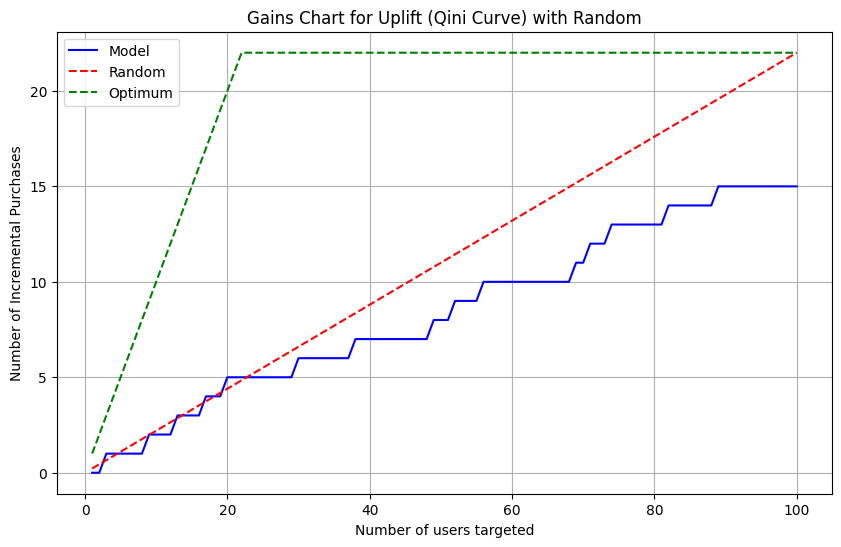

In [12]:
import matplotlib.pyplot as plt

# построение графиков
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cgain) + 1), cgain, label='Model', color='blue')
plt.plot(range(1, len(random) + 1), random, label='Random', color='red', linestyle='--')
plt.plot(range(1, len(optimum) + 1), optimum, label='Optimum', color='green', linestyle='--')
plt.xlabel('Number of users targeted')
plt.ylabel('Number of Incremental Purchases')
plt.title('Gains Chart for Uplift (Qini Curve) with Random')
plt.legend()
plt.grid(True)
plt.show()

## Задание

Ниже приведён код для отрисовки Qini-кривой. Дополните его и посчитайте Qini Score (площадь под кривой). 

Данные можете взять отсюда: `https://storage.yandexcloud.net/mle-data/sprint-5/discountuplift.csv`.

В данном датасете нас интересуют 2 колонки: `uplift_score` и `target_class`.

Расшифровка `target_class`:

- `0` — контрольная выборка, не купили товар ($y_c=0$, в наших терминах)
- `1` — контрольная выборка, купили товар ($y_c=1$, в наших терминах)
- `2` — выборка с воздействием (скидка), не купили товар ($y_t=0$, в наших терминах);
- `3` — выборка с воздействием (скидка), купили товар ($y_t=1$, в наших терминах).


In [13]:
# !mkdir datasets
# !wget https://storage.yandexcloud.net/mle-data/sprint-5/discountuplift.csv
# !mv discountuplift.csv datasets

In [20]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# загружаем DataFrame
discount = pd.read_csv("datasets/discountuplift.csv", sep="\t")
discount.sample(3, random_state=42)

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
9948,1,186.66,0,1,1,1,1,0,0,0,0,1,0.417925,0.166987,0.279740,0.135348,0.081161,2
2002,8,508.14,1,1,1,1,0,1,0,0,1,0,0.528632,0.061418,0.308849,0.101101,0.285057,2
3045,9,286.62,0,1,1,1,0,0,1,0,0,1,0.567822,0.022656,0.348541,0.060981,0.221080,2


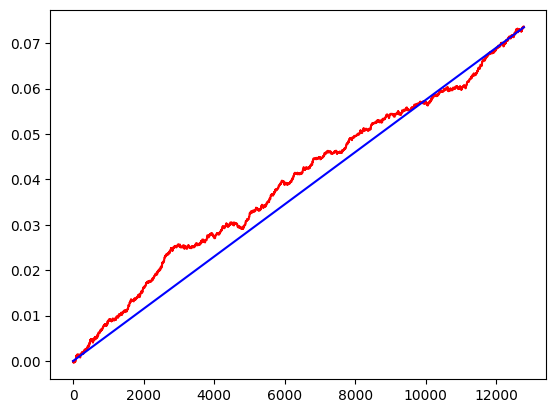

np.float64(33.22356)

In [70]:
# реализуем подсчёт Qini Score:
def qini_df(df):
    # 1. Отранжируем выборку по значению uplift в порядке убывания
    ranked = df.sort_values(by='uplift_score', ascending=False).reset_index(drop=True) # Ваш код здесь
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # посчитаем Qini-кривую и случайную прямую под ней
    ranked['uplift'] = ranked['n_t1/nt'] - ranked['n_c1/nc'] # Ваш код здесь
    # добавим случайную кривую
    end_point = ranked['uplift'].tail(1).values[0]
    ranked['random_uplift'] = np.linspace(0, end_point, ranked.shape[0]) # Ваш код здесь
    ranked["n"] = np.arange(ranked.shape[0]) # Ваш код здесь
    # немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()

qini_df(discount).round(5)

Это значит, что ваша модель лучше модели случайного воздействия (Qini Score положительный) — Baseline для других моделей создан. 

Итак, вы разобрались, как оценивать офлайн-качество uplift-моделей по их предсказанию. Дальше мы расскажем о том, как собрать выборку для правильной оценки качества, а также о том, как проводить A/B-тесты онлайн в случае uplift-моделирования.

# A/B-тесты и оценка качества онлайн